In [1]:
%load_ext autoreload
%autoreload 2
%cd ~/dev/neurad-studio

/home/gasparyanartur/dev/neurad-studio


In [2]:
import typing
from typing import Optional
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionImg2ImgPipeline, UNet2DConditionModel
from diffusers.image_processor import VaeImageProcessor
import torch
from transformers import AutoTokenizer
from transformers import CLIPTextModel


from nerfstudio.generative.diffusion_model import DiffusionModelId
from nerfstudio.generative.diffusion_model import import_encoder_class_from_model_name_or_path

model_id = DiffusionModelId.sd_v2_1
revision: str = "main"
variant: Optional[str] = None 

device = torch.device("cuda")
dtype = torch.float16



In [3]:
img_processor = VaeImageProcessor()

noise_scheduler = typing.cast(DDPMScheduler, DDPMScheduler.from_pretrained(
    model_id, subfolder="scheduler"
))

unet = typing.cast(UNet2DConditionModel, 
                   UNet2DConditionModel.from_pretrained(
    model_id,
    subfolder="unet",
    revision=revision,
    variant=variant,

))

tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
    revision=revision,
    use_fast=False,
)

text_encoder_cls = import_encoder_class_from_model_name_or_path(
    model_id, revision, subfolder="text_encoder"
)

text_encoder = typing.cast(CLIPTextModel, text_encoder_cls.from_pretrained(
    model_id,
    subfolder="text_encoder",
    revision=revision,
    variant=variant,
))

vae = typing.cast(AutoencoderKL, AutoencoderKL.from_pretrained(
    model_id,
    subfolder="vae",
    revision=revision,
    variant=variant,
))

models = {"img_processor": img_processor, "unet": unet, "tokenizer": tokenizer, "text_encoder": text_encoder, "vae": vae}

# TODO: Compile

vae.requires_grad_(False)
vae.to(device=device, dtype=dtype)

unet.requires_grad_(False)
unet.to(device=device, dtype=dtype)

text_encoder.requires_grad_(False)
text_encoder.to(device=device, dtype=dtype)

do_classifier_free_guidance: bool = True

#unet = torch.compile(unet)

...;

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


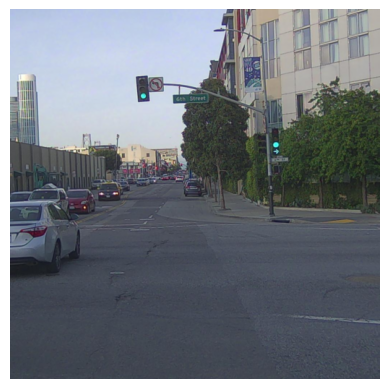

In [4]:
from pathlib import Path
from nerfstudio.generative.dynamic_dataset import make_img_tf_pipe, read_image
from nerfstudio.generative.utils import show_img


ex_img_path = Path("data/pandaset/001/camera/front_camera/00.jpg")
ex_img = read_image(ex_img_path, make_img_tf_pipe(dtype=dtype, crop_type="center"), device=device)
show_img(ex_img)

In [25]:
from diffusers.models import ControlNetModel

controlnet = ControlNetModel.from_unet(unet=unet)

In [15]:
all_modules_in_unet = set(n for n, m in unet.named_modules())
all_modules_in_controlnet = set(n for n, m in controlnet.named_modules())

all_unique = all_modules_in_controlnet.difference(all_modules_in_unet)
all_unique

{'controlnet_cond_embedding',
 'controlnet_cond_embedding.blocks',
 'controlnet_cond_embedding.blocks.0',
 'controlnet_cond_embedding.blocks.1',
 'controlnet_cond_embedding.blocks.2',
 'controlnet_cond_embedding.blocks.3',
 'controlnet_cond_embedding.blocks.4',
 'controlnet_cond_embedding.blocks.5',
 'controlnet_cond_embedding.conv_in',
 'controlnet_cond_embedding.conv_out',
 'controlnet_down_blocks',
 'controlnet_down_blocks.0',
 'controlnet_down_blocks.1',
 'controlnet_down_blocks.10',
 'controlnet_down_blocks.11',
 'controlnet_down_blocks.2',
 'controlnet_down_blocks.3',
 'controlnet_down_blocks.4',
 'controlnet_down_blocks.5',
 'controlnet_down_blocks.6',
 'controlnet_down_blocks.7',
 'controlnet_down_blocks.8',
 'controlnet_down_blocks.9',
 'controlnet_mid_block'}

In [8]:
unet_target_ranks = {
    "downblocks": {"attn": 4, "resnet": 4, "ff": 8, "proj": 8},
    "midblocks": {"attn": 8, "resnet": 8, "ff": 16, "proj": 16},
    "upblocks": {"attn": 8, "resnet": 8, "ff": 16, "proj": 16},
}

controlnet_target_ranks = {
    "downblocks": {"attn": 8, "resnet": 8, "ff": 16, "proj": 16},
    "midblocks": {"attn": 8, "resnet": 8, "ff": 16, "proj": 16},
}


In [17]:


from peft import get_peft_model, LoraConfig, inject_adapter_in_model

from nerfstudio.generative.diffusion_model import parse_target_ranks






unet_target_ranks = {
    "downblocks": {"attn": 4, "resnet": 4},
    "midblocks": {"attn": 4, "resnet": 4},
    "upblocks": {"attn": 4, "resnet": 4},
}

controlnet_target_ranks = {
    "downblocks": {"attn": 4, "resnet": 4},
    "midblocks": {"attn": 4, "resnet": 4},
}


unet_ranks = parse_target_ranks(unet_target_ranks)
controlnet_ranks = parse_target_ranks(controlnet_target_ranks)


{'unet': {'.*down_blocks.*attn.*to_[kvq]': 4,
  '.*down_blocks.*attn.*to_out\\.0': 4,
  '.*down_blocks.*resnets.*conv\\d*': 4,
  '.*down_blocks.*resnets.*time_emb_proj': 4,
  '.*mid_blocks.*attn.*to_[kvq]': 4,
  '.*mid_blocks.*attn.*to_out\\.0': 4,
  '.*mid_blocks.*resnets.*conv\\d*': 4,
  '.*mid_blocks.*resnets.*time_emb_proj': 4,
  '.*up_blocks.*attn.*to_[kvq]': 4,
  '.*up_blocks.*attn.*to_out\\.0': 4,
  '.*up_blocks.*resnets.*conv\\d*': 4,
  '.*up_blocks.*resnets.*time_emb_proj': 4},
 'controlnet': {'.*down_blocks.*attn.*to_[kvq]': 4,
  '.*down_blocks.*attn.*to_out\\.0': 4,
  '.*down_blocks.*resnets.*conv\\d*': 4,
  '.*down_blocks.*resnets.*time_emb_proj': 4,
  '.*mid_blocks.*attn.*to_[kvq]': 4,
  '.*mid_blocks.*attn.*to_out\\.0': 4,
  '.*mid_blocks.*resnets.*conv\\d*': 4,
  '.*mid_blocks.*resnets.*time_emb_proj': 4}}

In [37]:
peft_unet_conf = LoraConfig(
    r=8,
    init_lora_weights="gaussian",
    target_modules="|".join(unet_ranks.keys()),
    rank_pattern=unet_ranks,
    use_dora=True
)

peft_controlnet_conf = LoraConfig(
    r=8,
    init_lora_weights="gaussian",
    target_modules="|".join(controlnet_ranks.keys()),
    rank_pattern=controlnet_ranks,
    #modules_to_save=["controlnet_down_blocks", "controlnet_mid_block", "controlnet_cond_embedding"]
    modules_to_save=["controlnet_cond_embedding", *[f"controlnet_down_blocks.{i}" for i in range(12)], "controlnet_mid_block"],
    use_dora=True,
)

In [38]:
from copy import deepcopy


get_peft_model(deepcopy(controlnet), peft_controlnet_conf, "controlnet")

PeftModel(
  (base_model): LoraModel(
    (model): ControlNetModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (controlnet_cond_embedding): ModulesToSaveWrapper(
        (original_module): ControlNetConditioningEmbedding(
          (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (blocks): ModuleList(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (4): Conv2d(96, 9